In [135]:
from astropy.io import fits
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.cosmology import Planck13, z_at_value
import urllib
import healpy as hp

In [136]:
import time
start_time = time.time()

In [137]:
prob, distmu, distsigma, distnorm = hp.read_map('../bayestar.fits', field = [0,1,2,3])
hpy = hp.read_map('../bayestar.fits.gz')

NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


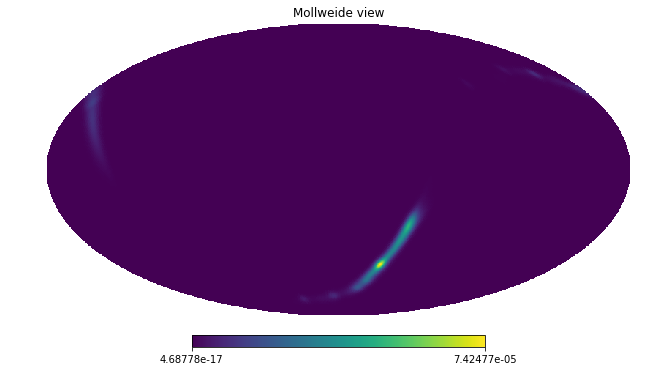

In [138]:
hp.mollview(prob, rot=180)

In [139]:
prob1 = list(prob)
npix = len(prob)
nside = hp.npix2nside(npix)

In [140]:
ipix = prob1.index(np.amax(prob1))
theta, phi = hp.pix2ang(nside, ipix)
ra = np.rad2deg(phi)
dec = np.rad2deg(0.5 * np.pi - theta)
ra, dec

(146.19767441860463, -49.896983831974104)

In [141]:
r = np.linspace(0,7000,num=1000)

In [142]:
def distance(rr, pixel):
    return distnorm[pixel]/(np.sqrt(2*np.pi)*distsigma[pixel])*np.exp(-(rr-distmu[pixel])**2 
                                                               /(2*distsigma[pixel])**2)*rr**2

Find the most probable distance of each pixel and the ra and dec for that pixel

In [143]:
most_probable_distance = []
ra, dec, std = [], [], []
probability = []

for pix1 in range(int(len(prob1))):
    dist = distance(r,pix1)
    dist = list(dist)
    inde = dist.index(np.amax(dist))
    most_probable_distance.append(inde * 7) #in units of Mpc
    theta, phi = hp.pix2ang(nside, pix1)
    ra.append(np.rad2deg(phi))
    dec.append(np.rad2deg(0.5 * np.pi - theta))
    probability.append(prob1[pix1])

Append all data needed for an sql to a list and sort it so highest probability is at the top

In [144]:
import time
#start_time = time.time()


data, z, stdz  = [], [], []
for i in range(int(len(probability))):
    if dec[i] > -10:
        data.append([probability[i] ,most_probable_distance[i],ra[i], dec[i], distsigma[i]])
    
data = sorted(data, key=lambda data: data[0]) #sort all data by the probability of the object
# being found in the ra and dec defined by that pixel

for i in range(100):
    z.append(z_at_value(Planck13.luminosity_distance,data[i][1]*u.Mpc )) #calculate the redshift
    stdz.append(z_at_value(Planck13.luminosity_distance,data[i][4]*u.Mpc ) )

#print("--- %s seconds ---" % (time.time() - start_time))

Excludes data that is unobservable to us

Form the sql

In [145]:
sql=' SELECT TOP 100 G.objID, GN.distance, G.z, G.ra, G.dec FROM Galaxy as G JOIN dbo.fGetNearbyObjEq(' + str(data[44][2]) + ','+ str(data[44][3])+', 1) AS GN ON G.objID = GN.objID WHERE z >' + str(z[44]-stdz[44]) + ' and z <' + str(z[44]+stdz[44]) 

In [146]:
#params = urllib.parse.urlencode({'cmd': sql, 'format': 'fits'}) #open the connection and run the sql
#urllib.request.urlretrieve(url+params, 'gt.fits'); #collect the data

Print data from sql

In [147]:
#hud = fits.open('gt.fits') # read the file the data was output to
#print(hud[0].data)

In [155]:

data_for_telescope = []
for i in range(len(z)):
    sql=    ' SELECT TOP 100 G.objID, GN.distance, G.z, G.ra, G.dec FROM Galaxy as G JOIN dbo.fGetNearbyObjEq(' + str(data[i][2]) + ','+ str(data[i][3])+', 1) AS GN ON G.objID = GN.objID WHERE z >' + str(z[i]-stdz[i]) 
    #performs sql for most probable sky locations
    params = urllib.parse.urlencode({'cmd': sql, 'format': 'fits'}) #open the connection and run the sql
    urllib.request.urlretrieve(url+params, 'gt1.fits'); #collect and save the data
    hud = fits.open('gt1.fits') # read the file the data was output to
    if len(hud) == 1:
        continue
    else:
        galaxies = (np.array(hud[1].data))
        for j in range(len(galaxies)):
            theta = 0.5 * np.pi - np.deg2rad(galaxies[j][4])
            phi = np.deg2rad(galaxies[j][3])
            pix = hp.ang2pix(nside, theta, phi)
            d = Planck13.luminosity_distance(galaxies[j][2])
            prob_of_gal = distance((d.value)/1000, pix)
            data_for_telescope.append([galaxies[j][0], galaxies[j][2], galaxies[j][3], galaxies[j][4]
                                       , d.value, prob_of_gal])
data_for_telescope = sorted(data_for_telescope, key=lambda data_for_telescope: data_for_telescope[5])

print("--- %s seconds ---" % (time.time() - start_time))

--- 3780.048670768738 seconds ---


## Need to do: 
#####   1) how to autorun 
#####   2) exclude unobservable data 
#####    3) how to autodownload data 
#####    4) how to pass data to telescope

In [156]:
len(data_for_telescope)

1177